#  Прогнозирование заказов такси

## Подготовка

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate, train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
taxi_orders = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
taxi_orders.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим, расположены ли данные в хронологическом порядке:

In [3]:
taxi_orders.index.is_monotonic

True

In [4]:
taxi_orders.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропуски в данных отсутствуют. Для обучения моделей имеются данные за 2018 год с начала марта по конец августа. Ресемплируем данные по одному часу:

In [5]:
taxi_orders = taxi_orders.resample('1H').sum()

## Анализ

Проверим наличие трендов и сезонности в данных.

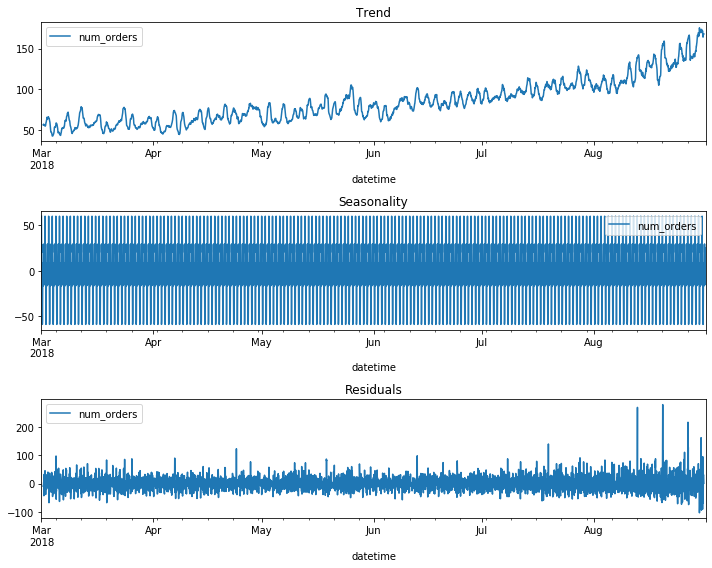

In [6]:
decomposed = seasonal_decompose(taxi_orders)

plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Можно заметить, что количество заказов увеличивается в течение данного временного промежутка. Для выявления сезонности возьмём первые 5 дней июня.

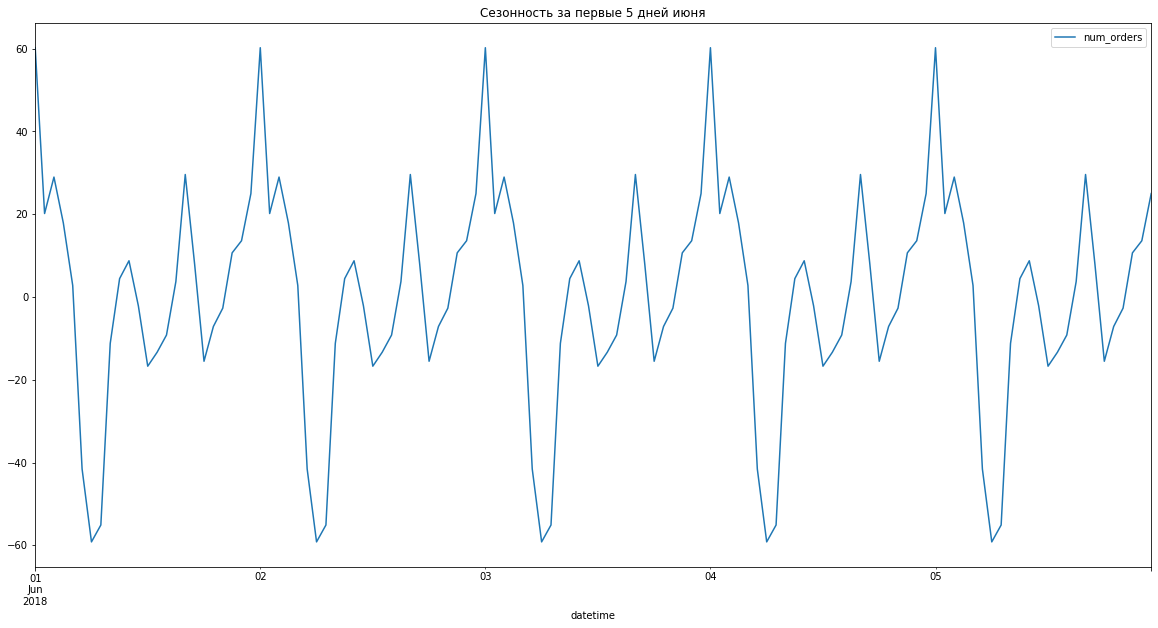

In [7]:
plt.figure(figsize=(20, 10))
decomposed.seasonal['2018-06-01':'2018-06-05'].plot(ax=plt.gca())
plt.title('Сезонность за первые 5 дней июня')
plt.show()

Из графика видно, что наибольшее количество заказов приходится на ночные часы. И наоборот, в районе 6-7 часов утра количество заказов минимально.

## Обучение

Для создания признаков воспользуемся представленной ниже функцией.

In [8]:
def make_features(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range (1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [9]:
make_features(taxi_orders, 10, 10)

Разделим данные на обучающую и тестовую выборки. Выделим признаки и целевой признак.

In [10]:
train, test = train_test_split(taxi_orders, shuffle=False, test_size=0.1)
train = train.dropna()

X_train, y_train = train.drop('num_orders', axis=1), train['num_orders']
X_test, y_test = test.drop('num_orders', axis=1), test['num_orders']

Перед проверкой моделей узнаем значение RMSE для константной модели:

In [11]:
pred_median = np.ones(y_test.shape) * y_train.median()

print(f'RMSE константной модели: {(mean_squared_error(y_test, pred_median))**0.5:.2f}')

RMSE константной модели: 87.15


А также значение для модели по предыдущему значению ряда:

In [12]:
pred_previous = y_test.shift(fill_value=y_train.iloc[-1])

print(f'RMSE модели по предыдущему значению ряда: {(mean_squared_error(y_test, pred_previous))**0.5:.2f}')

RMSE модели по предыдущему значению ряда: 58.86


Значение RMSE для константной модели сильно выше допустимого значения. RMSE по предыдущему значению ряда ближе к целевому значению, но всё ещё недостаточно.

### Линейная регрессия

In [13]:
%%time
linear_regression = LinearRegression()

cv = TimeSeriesSplit(n_splits=5)

cv_result = cross_validate(
    linear_regression,
    X_train, y_train,
    cv=cv,
    scoring='neg_mean_squared_error'
)
print(f'RMSE модели линейной регрессии после кросс-валидации {(-cv_result["test_score"].mean())**0.5:.2f}')

RMSE модели линейной регрессии после кросс-валидации 31.77
CPU times: user 248 ms, sys: 217 ms, total: 465 ms
Wall time: 406 ms


### Случайный лес

In [15]:
%%time
random_forest = RandomForestRegressor(random_state=12345)

param_grid = {
    "n_estimators": range(1, 30),
    "max_depth": range(1, 10),
}
grid_search = GridSearchCV(
    random_forest,
    param_grid=param_grid,
    cv=cv,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)
grid_search.fit(X_train, y_train)

print(f'RMSE модели случайного леса с параметрами {grid_search.best_params_} равна {(-grid_search.best_score_)**0.5:.2f}')

RMSE модели случайного леса с параметрами {'max_depth': 9, 'n_estimators': 29} равна 26.24
CPU times: user 2min 31s, sys: 467 ms, total: 2min 31s
Wall time: 2min 32s


### Градиентный бустинг

In [16]:
%%time
gbr = GradientBoostingRegressor(random_state=12345)

param_grid = {
    "n_estimators": range(1, 40),
    "max_depth": range(1, 10),
    "learning_rate": [0.1, 1],
}
grid_search = GridSearchCV(
    gbr,
    param_grid=param_grid,
    cv=cv,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print(f'RMSE модели градиентного бустинга с параметрами {grid_search.best_params_} равна {(-grid_search.best_score_)**0.5:.2f}')

RMSE модели градиентного бустинга с параметрами {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 39} равна 26.05
CPU times: user 6min 39s, sys: 155 ms, total: 6min 39s
Wall time: 6min 42s


## Тестирование

### Линейная регрессия

In [17]:
%%time
linear_regression.fit(X_train, y_train)
predict_test = linear_regression.predict(X_test)
mse_test = mean_squared_error(y_test, predict_test)
print(f'RMSE модели линейной регрессии на тестовой выборке равна {mse_test**0.5:.2f}')

RMSE модели линейной регрессии на тестовой выборке равна 53.45
CPU times: user 11 ms, sys: 3.93 ms, total: 14.9 ms
Wall time: 7.86 ms


### Случайный лес

In [18]:
%%time
random_forest = RandomForestRegressor(max_depth=9, n_estimators=29)

random_forest.fit(X_train, y_train)
predict_test = random_forest.predict(X_test)
mse_test = mean_squared_error(y_test, predict_test)
print(f'RMSE модели случайного леса на тестовой выборке равна {mse_test**0.5:.2f}')

RMSE модели случайного леса на тестовой выборке равна 46.32
CPU times: user 658 ms, sys: 6 µs, total: 658 ms
Wall time: 656 ms


### Градиентный бустинг

In [19]:
%%time
gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=6, n_estimators=39)

gbr.fit(X_train, y_train)
predict_test = gbr.predict(X_test)
mse_test = mean_squared_error(y_test, predict_test)
print(f'RMSE модели градиентного бустинга на тестовой выборке равна {mse_test**0.5:.2f}')

RMSE модели градиентного бустинга на тестовой выборке равна 44.85
CPU times: user 451 ms, sys: 0 ns, total: 451 ms
Wall time: 449 ms


## Вывод

В результате при использовании моделей случайного леса и градиентного бустинга удалось получить значение метрики RMSE ниже 48.